# **Crop Logos and Augmentation**
Đầu tiên, từ tập ảnh download được ở bước trước, nhóm tiến hành lọc ra các hình ảnh không liên quan và đánh nhãn cho các hình ảnh còn lại. Ở bước này nhóm sẽ cắt các ảnh logo từ tập ảnh có label. Sau đó, nhóm sẽ thực hiện một số phép biến đổi trên các ảnh logo có được từ bước trên để tăng cường thêm dữ liệu.

In [0]:
# Import library
from skimage import io
from skimage import util
from skimage import filters
from skimage import transform
import numpy as np
import random
import os

In [0]:
# Define util functions

def read_all_file_in_dir(in_dir):
  files = []
  for path, dir_names, file_names in os.walk(in_dir):
    files += file_names
    break
  return files

def read_all_dir_in_dir(in_dir):
  dirs = []
  for path, dir_names, file_names in os.walk(in_dir):
    dirs += dir_names
    break
  return dirs

def read_labels(label_dir, img_name):
  labels = []
  f = open(os.path.join(label_dir, img_name + '.txt'))
  for line in f:
    label = [float(x) for x in line.split()]
    labels.append(label)
  f.close()
  return labels

def augment_image(img, out_dir, index=0, ext='png'):
  blurred_img = filters.gaussian(img, 1.5, multichannel=True)
  noised_img = util.random_noise(img, mode='gaussian', var=random.uniform(0.005, 0.05))
  horizontal_resized_img = transform.resize(img, (img.shape[0], int(img.shape[1] * random.uniform(1.2, 2.5))))
  vertical_resized_img = transform.resize(img, (int(img.shape[0] * random.uniform(1.2, 2.5)), img.shape[1]))
  io.imsave(os.path.join(out_dir, f'logo_{index}.{ext}'), util.img_as_ubyte(blurred_img))
  io.imsave(os.path.join(out_dir, f'logo_{index+1}.{ext}'), util.img_as_ubyte(noised_img))
  io.imsave(os.path.join(out_dir, f'logo_{index+2}.{ext}'), util.img_as_ubyte(horizontal_resized_img))
  io.imsave(os.path.join(out_dir, f'logo_{index+3}.{ext}'), util.img_as_ubyte(vertical_resized_img))
  return index + 4

def crop_logo_from_img(img, labels, out_dir, index=0, ext='png', augmented_dir='./dataset/logos/augmented_logos'):
  shape = img.shape
  for label in labels:
    x = label[1] * shape[1]
    y = label[2] * shape[0]
    width = label[3] * shape[1]
    height = label[4] * shape[0]
    logo = img[int(y-height / 2):int(y+height/2), int(x-width/2):int(x+width/2), :]
    io.imsave(os.path.join(out_dir, f'logo_{index}.{ext}'), logo)
    index = augment_image(util.img_as_ubyte(logo), augmented_dir, index=index+1, ext=ext)
  return index

In [0]:
# Dataset directory
img_dir = './dataset/images'
label_dir = './dataset/labels'
logo_dir = './dataset/logos'
labels_file = './dataset/logo_labels.csv'
augmented_logo_dir = './dataset/logos/augmented_logos'

In [0]:
# Create folder to store logos
if not os.path.exists(logo_dir):
  os.mkdir(logo_dir)
if not os.path.exists(augmented_logo_dir):
  os.mkdir(augmented_logo_dir)

In [66]:
# Read child folders in image folder
child_dir_names = read_all_dir_in_dir(img_dir)
logo_labels = []

# Read all images in each child folder
index = 0
for dir_name in child_dir_names:
  child_image_dir = os.path.join(img_dir, dir_name)
  child_label_dir = os.path.join(label_dir, dir_name)

  file_names = read_all_file_in_dir(child_image_dir)
  
  for file_name in file_names:
    ext = file_name.split('.')[-1]
    img = io.imread(os.path.join(child_image_dir, file_name))
    labels = read_labels(child_label_dir, file_name.split('.')[0])
    new_index = crop_logo_from_img(img, labels=labels, out_dir=logo_dir, index=index, ext = ext)
    logo_labels += [[(f'augmented_logos/logo_{x}.{ext}', f'logo_{x}.{ext}')[x % 5 == 0], dir_name] for x in range(index, new_index)]
    index = new_index

# Save labels to csv file
np.savetxt(labels_file, np.array(logo_labels), delimiter='\t', fmt='%s')

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: ./dataset/logos/augmented_logos/logo_901.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: ./dataset/logos/augmented_logos/logo_911.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


In [0]:
import pandas as pd

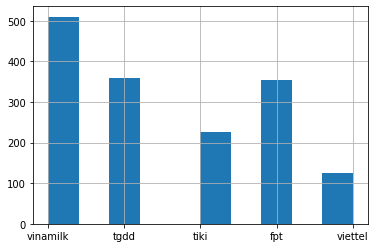

In [68]:
df = pd.DataFrame(logo_labels, columns=['File name', 'Company'])
df['Company'].hist()

In [0]:
def augment_data_from_file_name_of_tiki(file_name, in_dir, out_dir, company='tiki'):
  global index, logo_labels
  ext = file_name.split('.')[-1]
  img = io.imread(os.path.join(in_dir, file_name))
  noised_img = util.random_noise(img, mode='gaussian', var=random.uniform(0.005, 0.05))
  io.imsave(os.path.join(out_dir, f'logo_{index}.{ext}'), util.img_as_ubyte(noised_img))
  logo_labels.append([f'augmented_logos/logo_{index}.{ext}', company])
  index += 1

def augment_data_from_file_name_of_viettel(file_name, in_dir, out_dir, company='viettel'):
  global index, logo_labels
  ext = file_name.split('.')[-1]
  img = io.imread(os.path.join(in_dir, file_name))
  noised_img = util.random_noise(img, mode='gaussian', var=random.uniform(0.005, 0.05))
  horizontal_resized_img = transform.resize(img, (img.shape[0], int(img.shape[1] * random.uniform(1.2, 2.5))))
  vertical_resized_img = transform.resize(img, (int(img.shape[0] * random.uniform(1.2, 2.5)), img.shape[1]))
  io.imsave(os.path.join(out_dir, f'logo_{index}.{ext}'), util.img_as_ubyte(noised_img))
  io.imsave(os.path.join(out_dir, f'logo_{index+1}.{ext}'), util.img_as_ubyte(horizontal_resized_img))
  io.imsave(os.path.join(out_dir, f'logo_{index+2}.{ext}'), util.img_as_ubyte(vertical_resized_img))
  logo_labels += [[f'augmented_logos/logo_{x}.{ext}', company] for x in range(index, index + 3)]
  index += 3

In [0]:
tiki_df = df[df['Company'] == 'tiki']
viettel_df = df[df['Company'] == 'viettel']

In [0]:
tiki_df['File name'].apply(augment_data_from_file_name_of_tiki, args=(logo_dir, augmented_logo_dir))
viettel_df['File name'].apply(augment_data_from_file_name_of_viettel, args=(logo_dir, augmented_logo_dir))

In [0]:
np.savetxt(labels_file, np.array(logo_labels), delimiter='\t', fmt='%s')

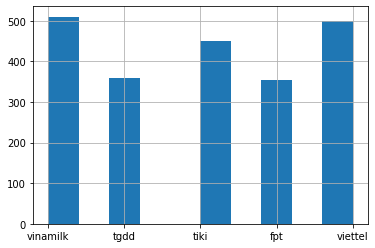

In [74]:
df = pd.DataFrame(logo_labels, columns=['File name', 'Company'])
df['Company'].hist()